# CT, specifically head CT w/o contrast, is the common diagnosis modality for TBI patients. This notebook shows the CT utilization data in ICU for mild TBI patients. 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import psycopg2
import getpass

import os

# Create a database connection
# Credentials saved on local environment 
# in HOME directory, use vim .bash_profile to edit

dbuser = os.environ.get('dbuser')
dbhost = os.environ.get('dbhost')
dbname = os.environ.get('dbname')
dbschema = os.environ.get('dbschema')
dbpwd = os.environ.get('dbpwd')
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=dbuser, host=dbhost, 
                       password=dbpwd)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(dbschema))


In [2]:
#prepare data frame
query_TBI_ML = \
"""
/*query all the data including vitals chart events*/
SELECT  
		ad.hadm_id,
        pa.gender,
		(DATE_PART('year', ad.admittime::date) - DATE_PART('year', pa.dob::date)) AS age,
		gcs.gcs,
        ne.description,
		ad.hospital_expire_flag   
FROM mimiciii.admissions AS ad
INNER JOIN mimiciii.icustays AS icu ON ad.hadm_id = icu.hadm_id
INNER JOIN mimiciii.pivoted_gcs AS gcs ON icu.icustay_id = gcs.icustay_id
INNER JOIN mimiciii.noteevents AS ne ON ne.hadm_id = ad.hadm_id
INNER JOIN mimiciii.diagnoses_icd AS d ON d.hadm_id = ad.hadm_id
INNER JOIN mimiciii.patients AS pa ON pa.subject_id = ad.subject_id
WHERE 	
		(
			(d.icd9_code >= '8010' AND d.icd9_code < '8019')
		OR 
			(d.icd9_code >= '8030' AND d.icd9_code < '8049')
		OR
			(d.icd9_code >= '85' AND d.icd9_code < '8541')
		OR
			(d.icd9_code >= '951' AND d.icd9_code < '953')
		OR
			d.icd9_code IN ('95555', '95901')
		)
/*		AND
		ad.hospital_expire_flag = 1 */

 
"""
data_TBI_ML = pd.read_sql_query(query_TBI_ML,con)
#data_TBI = pd.DataFrame(data_TBI)
#data_TBI.fillna({'label':'Other', 'flag':'normal'}, inplace=True)
#data_TBI_ML.drop_duplicates(inplace = True)
#remove negative delay rows
#data_TBI_ML.drop(data_TBI_ML[data_TBI_ML.chartdelayhrs <0].index, inplace=True)
#remove hadm_id
#data_TBI_ML.drop(['hadm_id'], axis=1, inplace=True)

data_TBI_ML.to_csv("TBI_UM_CT.csv", index=False)

In [3]:
data_TBI_ML.hadm_id.nunique()

2590

In [4]:
data_TBI_ML.head()

,hadm_id,gender,age,gcs,description,hospital_expire_flag
0,191578,M,62.0,15.0,CHEST (PORTABLE AP),0
1,191578,M,62.0,15.0,P VEN DUP EXTEXT BIL (MAP/DVT) PORT,0
2,191578,M,62.0,15.0,CHEST (PORTABLE AP),0
3,191578,M,62.0,15.0,CT HEAD W/O CONTRAST,0
4,191578,M,62.0,15.0,CT HEAD W/O CONTRAST,0


In [52]:
# import pandas as pd
# from datetime import datetime
# dtypes={"gender": 'str', "age": int, "hadm_id":'str', "hospital_expire_flag":int, "gcs":float,"description":'str'}

# data_TBI_ML = pd.read_csv("TBI_UM.csv", dtype = dtypes)#,parse_dates=[4,5,9], infer_datetime_format=True)



In [5]:
data_TBI_ML.columns

Index(['hadm_id', 'gender', 'age', 'gcs', 'description',
       'hospital_expire_flag'],
      dtype='object')

In [6]:

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
#github cannot display plotly graph

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib.ticker as mtick

import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})

In [7]:
print("unique values of TBI admission#:", data_TBI_ML.hadm_id.nunique())
data_TBI_ML.head()

unique values of TBI admission#: 2590


,hadm_id,gender,age,gcs,description,hospital_expire_flag
0,191578,M,62.0,15.0,CHEST (PORTABLE AP),0
1,191578,M,62.0,15.0,P VEN DUP EXTEXT BIL (MAP/DVT) PORT,0
2,191578,M,62.0,15.0,CHEST (PORTABLE AP),0
3,191578,M,62.0,15.0,CT HEAD W/O CONTRAST,0
4,191578,M,62.0,15.0,CT HEAD W/O CONTRAST,0


In [8]:
#remove entries that have age >120 years old
data_TBI_ML.drop(data_TBI_ML[data_TBI_ML.age > 120].index, inplace=True)


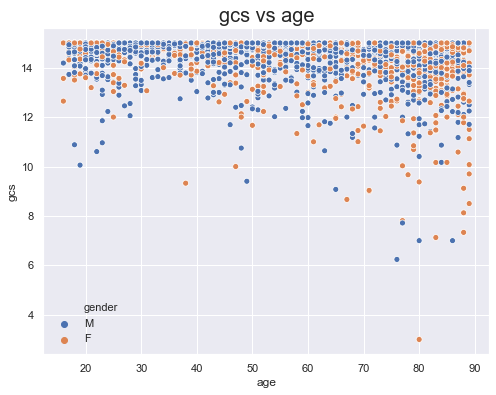

In [9]:
g =sns.scatterplot(x="age", y="gcs",
              hue="gender",
              data=data_TBI_ML.groupby(['hadm_id']).aggregate({'gender':'min', 
                                             'age':'min','gcs':'mean'})).set_title("gcs vs age", fontsize = 20)

## 64% of all TBI admissions in ICU are mild cases
## 87% of these mTBI cases performed Head CT

Text(0.5, 1.0, 'GCS by Severity')

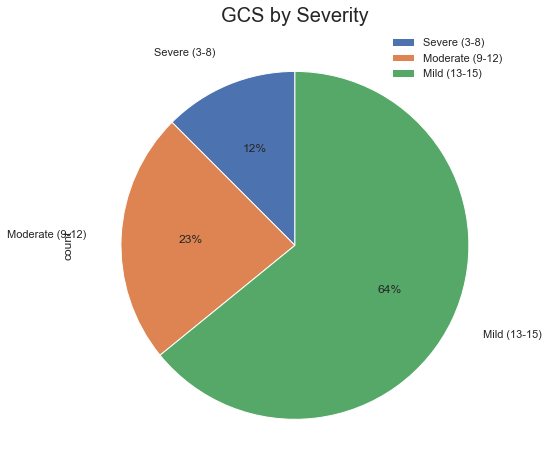

In [50]:
df_gcs = data_TBI_ML[['gcs','hadm_id']].groupby(['gcs'])['hadm_id'] \
                             .nunique() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)

demo2 = df_gcs.groupby(pd.cut(df_gcs['gcs'], 
                             bins = [2, 8, 12, 15], 
                             labels = ["Severe (3-8)", "Moderate (9-12)", 
                                        "Mild (13-15)" ])).aggregate({'count':'sum'})

# demo2.plot.pie(y='count', 
#                figsize=(12, 8), 
#                autopct='%1.0f%%', 
#                pctdistance=0.6, 
#                labeldistance=1.2,
#                sort_columns = True
#                ).set_title("GCS by Severity", fontsize = 20)
ax = demo2.plot.pie(y='count',
                figsize=(12, 8), 
               autopct='%1.0f%%', 
               pctdistance=0.6, 
               labeldistance=1.2,
               sort_columns = True,
            startangle=-270)

ax.set_title('GCS by Severity', fontsize = 20)

Text(0.5, 1.0, 'Top 10 Chart Events in Mild TBI')

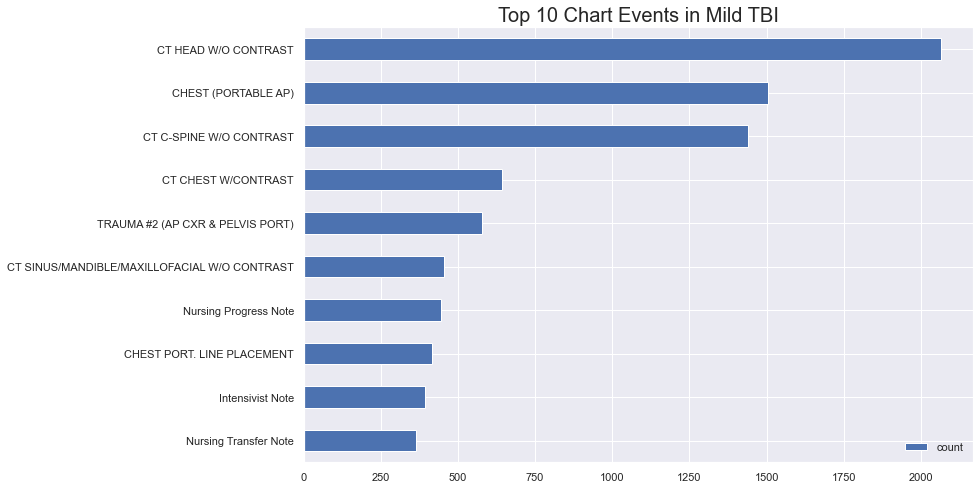

In [83]:
df_top_ce = data_TBI_ML.loc[(data_TBI_ML['gcs'] >= 13)].groupby(['description'])['hadm_id'] \
                             .nunique() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(11)
tc = int(df_top_ce.loc[df_top_ce['description']=='Report']['count'])
df_top_ce['%'] = df_top_ce['count']/tc

# df_top_ce.plot.barh(x = 'description', 
#                       figsize=(10, 7),
#                     sort_columns = True,
#                     title = "Top 10 Chart Events in Mild TBI"
#                      ).invert_yaxis()

ax = df_top_ce.iloc[1:].plot.barh(x='description',
                                  y = 'count',
                                    figsize=(12, 8),)

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_ylabel('')
ax.set_title('Top 10 Chart Events in Mild TBI', fontsize = 20)

# x_offset = -0.03
# y_offset = 0.02
# i = 0
# for p in ax.patches:
#     b = p.get_bbox()
#     val = "{:.2%}".format(df_top_ce.iloc[i+1]['share'])        
#     ax.annotate(val, ((b.x1 )+ x_offset, b.y1))
#     if i < len(df_top_ce)-1:
#         i=i+1


In [78]:
df_top_ce.reset_index(drop=True, inplace = True)
df_top_ce.style.format({
    '%': '{:,.2%}'.format,
})


,description,count,%
0,Report,2355,100.00%
1,CT HEAD W/O CONTRAST,2066,87.73%
2,CHEST (PORTABLE AP),1505,63.91%
3,CT C-SPINE W/O CONTRAST,1439,61.10%
4,CT CHEST W/CONTRAST,642,27.26%
5,TRAUMA #2 (AP CXR & PELVIS PORT),579,24.59%
6,CT SINUS/MANDIBLE/MAXILLOFACIAL W/O CONTRAST,456,19.36%
7,Nursing Progress Note,445,18.90%
8,CHEST PORT. LINE PLACEMENT,417,17.71%
9,Intensivist Note,392,16.65%
